<a href="https://colab.research.google.com/github/OJB-Quantum/Quantum-Native-Solvers/blob/main/Colab%20Example%20Notebooks/Spin_Dynamics_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [19]:
!pip install qiskit-aer pylatexenc

Simulating time t = 0.000 ...
Simulating time t = 0.263 ...
Simulating time t = 0.526 ...
Simulating time t = 0.789 ...
Simulating time t = 1.053 ...
Simulating time t = 1.316 ...
Simulating time t = 1.579 ...
Simulating time t = 1.842 ...
Simulating time t = 2.105 ...
Simulating time t = 2.368 ...
Simulating time t = 2.632 ...
Simulating time t = 2.895 ...
Simulating time t = 3.158 ...
Simulating time t = 3.421 ...
Simulating time t = 3.684 ...
Simulating time t = 3.947 ...
Simulating time t = 4.211 ...
Simulating time t = 4.474 ...
Simulating time t = 4.737 ...
Simulating time t = 5.000 ...
Simulation finished.
Plotting heat‑map ...


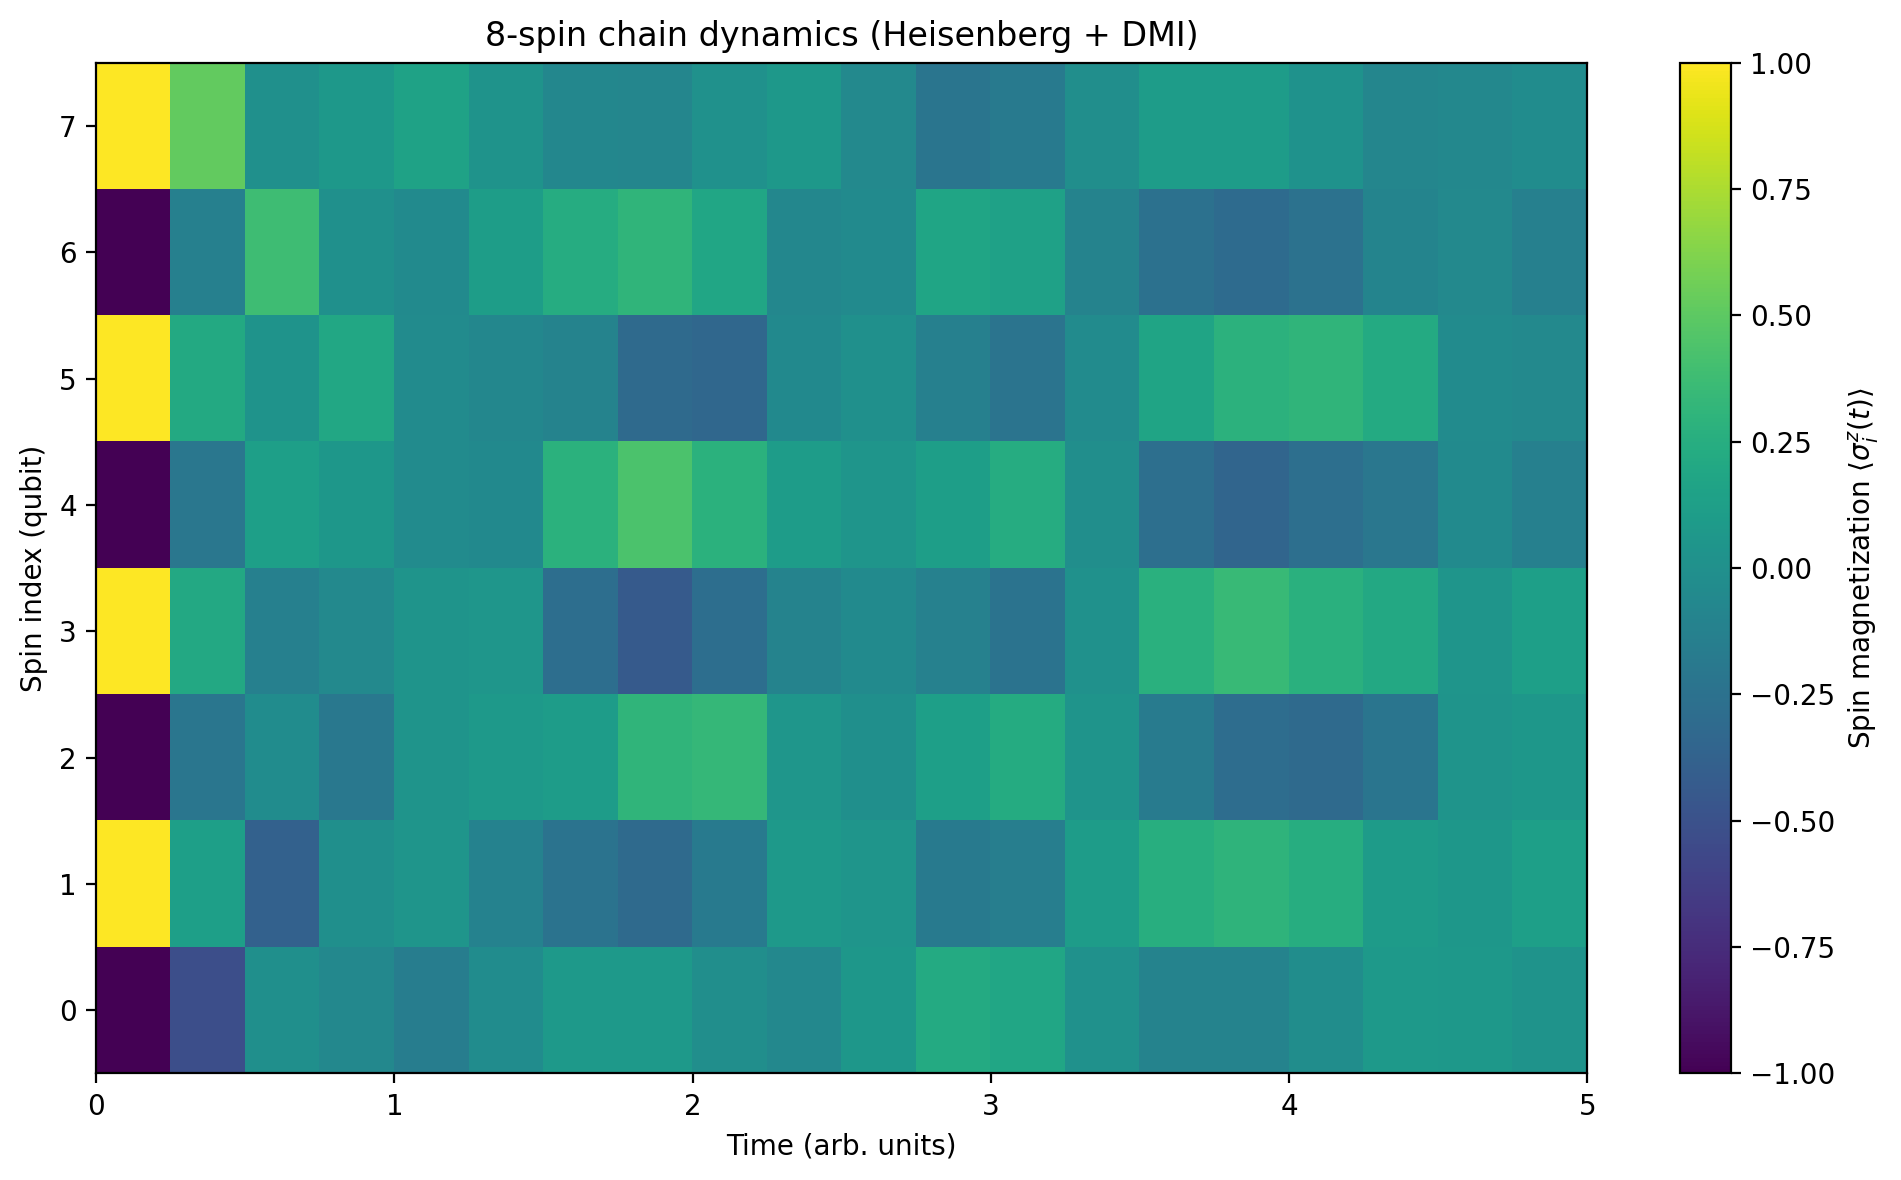

Plotting circuit for a single Trotter step ...


<Figure size 1280x960 with 0 Axes>


All done – the two figures have been shown.


In [20]:
#!/usr/bin/env python3
"""
Spintronic dynamics simulation using Qiskit.

The script builds the Hamiltonian of a 1‑D Heisenberg spin chain with
Dzyaloshinskii‑Moriya interaction (DMI) and an external magnetic field,
evolves an initial Néel state with a Trotterized Pauli‑evolution gate,
and visualizes

* a heat‑map of  ⟨σᶻ_i(t)⟩  for every spin,
* a high‑DPI picture of the quantum circuit for a single Trotter step.

All plots are shown on‑screen one after the other
"""

# ----------------------------------------------------------------------
# Step 1 – Imports (everything you already have in the main script)
# ----------------------------------------------------------------------
from __future__ import annotations

import sys
from typing import List

import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.synthesis import LieTrotter

plt.rcParams['figure.dpi'] = 200

# ----------------------------------------------------------------------
# Step 2 – Constants (simulation parameters)
# ----------------------------------------------------------------------
N_SPINS: int = 8           # Number of qubits in the chain
TROTTER_STEPS: int = 4     # Repetitions of the Lie‑Trotter product formula

# Hamiltonian coefficients
J_X: float = 1.0           # XX coupling
J_Y: float = 1.0           # YY coupling
J_Z: float = 1.2           # ZZ coupling (anisotropic)
H_Z: float = 0.5           # Uniform Z‑field
D_Z: float = 0.3           # DMI strength (D_z)

# Time‑sampling for the sweeps
T_FINAL: float = 5.0
T_STEPS: int = 20
TIMES: np.ndarray = np.linspace(0.0, T_FINAL, T_STEPS)


# ----------------------------------------------------------------------
# Step 3 – Helper functions
# ----------------------------------------------------------------------
def pauli_string(paulis: str, start: int, n_qubits: int) -> str:
    """Return a full‑length Pauli string.

    ``paulis`` is placed starting at ``start``; the remaining positions are
    filled with the identity operator ``'I'``.

    Args:
        paulis: Short Pauli word, e.g. ``'XX'`` or ``'Z'``.
        start:  Index of the left‑most qubit the word acts on.
        n_qubits: Total number of qubits in the circuit.

    Returns:
        A string of length ``n_qubits`` consisting of ``'I'`` and the supplied
        Pauli letters.
    """
    p_list = ["I"] * n_qubits
    for offset, p in enumerate(paulis):
        p_list[start + offset] = p
    return "".join(p_list)


def build_hamiltonian(
    n_spins: int,
    j_x: float,
    j_y: float,
    j_z: float,
    h_z: float,
    d_z: float,
) -> SparsePauliOp:
    """Construct the full system Hamiltonian as a ``SparsePauliOp``.

    The Hamiltonian contains

    * nearest‑neighbour Heisenberg terms,
    * a DMI contribution  :math:`D_z (X_i Y_{i+1} - Y_i X_{i+1})`,
    * a uniform Zeeman field :math:`h_z Z_i`.

    Args:
        n_spins: Number of spins (qubits) in the chain.
        j_x: XX coupling strength.
        j_y: YY coupling strength.
        j_z: ZZ coupling strength.
        h_z: Z‑field strength.
        d_z: DMI strength.

    Returns:
        ``SparsePauliOp`` representing the Hamiltonian.
    """
    terms: List[str] = []
    coeffs: List[float] = []

    # Nearest‑neighbour contributions
    for i in range(n_spins - 1):
        # Heisenberg XX, YY, ZZ
        terms.append(pauli_string("XX", i, n_spins))
        coeffs.append(j_x)

        terms.append(pauli_string("YY", i, n_spins))
        coeffs.append(j_y)

        terms.append(pauli_string("ZZ", i, n_spins))
        coeffs.append(j_z)

        # DMI: D_z * (X_i Y_{i+1} - Y_i X_{i+1})
        terms.append(pauli_string("XY", i, n_spins))
        coeffs.append(d_z)

        terms.append(pauli_string("YX", i, n_spins))
        coeffs.append(-d_z)

    # Uniform external field
    for i in range(n_spins):
        terms.append(pauli_string("Z", i, n_spins))
        coeffs.append(h_z)

    return SparsePauliOp(terms, coeffs=coeffs)


def neel_statevector(n_spins: int) -> Statevector:
    """Return the |0101…⟩ (Néel) state as a ``Statevector``.

    The Néel state has spin‑up on even sites and spin‑down on odd sites.

    Args:
        n_spins: Number of qubits.

    Returns:
        ``Statevector`` for the Néel product state.
    """
    circuit = QuantumCircuit(n_spins)
    for qubit in range(1, n_spins, 2):
        circuit.x(qubit)
    return Statevector.from_instruction(circuit)


def expectation_z(state: Statevector, n_spins: int) -> np.ndarray:
    """Calculate ⟨σᶻ_i⟩ for all sites from a given statevector.

    Args:
        state: Statevector after time evolution.
        n_spins: Number of qubits.

    Returns:
        1‑D ``numpy`` array of length ``n_spins`` containing the expectation
        values (real numbers).
    """
    exp_vals = np.empty(n_spins, dtype=float)
    for i in range(n_spins):
        op = SparsePauliOp(pauli_string("Z", i, n_spins), coeffs=[1.0])
        exp = state.expectation_value(op)
        exp_vals[i] = np.real_if_close(exp)
    return exp_vals


def run_simulation(
    hamiltonian: SparsePauliOp,
    n_spins: int,
    times: np.ndarray,
    trotter_steps: int,
) -> np.ndarray:
    """Evolve the Néel state and return the spin‑magnetization dynamics.

    The time evolution uses a Lie‑Trotter product formula with the requested
    number of repetitions.  For each sampling time a statevector is obtained
    and the local ``Z`` expectations are recorded.

    Args:
        hamiltonian: System Hamiltonian as a ``SparsePauliOp``.
        n_spins: Number of qubits.
        times: 1‑D array of time‑points at which the state is sampled.
        trotter_steps: Repetitions of the Lie‑Trotter product formula.

    Returns:
        2‑D ``numpy`` array with shape ``(len(times), n_spins)``.  Entry
        ``[k, i]`` is ⟨σᶻ_i(t_k)⟩.
    """
    # Initial Néel state (|0101…⟩)
    psi0 = neel_statevector(n_spins)

    # Pre‑build the observable operators once
    z_ops = [
        SparsePauliOp(pauli_string("Z", i, n_spins), coeffs=[1.0])
        for i in range(n_spins)
    ]

    dynamics = np.zeros((len(times), n_spins), dtype=float)

    for idx, t in enumerate(times):
        print(f"Simulating time t = {t:.3f} ...", flush=True)

        evo_gate = PauliEvolutionGate(
            hamiltonian,
            time=t,
            synthesis=LieTrotter(reps=trotter_steps),
        )

        psi_t = psi0.evolve(evo_gate)

        for i, op in enumerate(z_ops):
            exp_val = psi_t.expectation_value(op)
            dynamics[idx, i] = float(np.real_if_close(exp_val))

    print("Simulation finished.")
    return dynamics


def plot_heatmap(
    spin_data: np.ndarray,
    times: np.ndarray,
    n_spins: int,
) -> None:
    """Draw a heat‑map of ⟨σᶻ_i(t)⟩.

    The colour axis runs from –1 to +1 (the eigenvalues of σᶻ).

    Args:
        spin_data: 2‑D array of shape ``(len(times), n_spins)``.
        times: Sampling times (x‑axis of the heat‑map).
        n_spins: Number of spins (y‑axis).
    """
    print("Plotting heat‑map ...")
    plt.figure(figsize=(10, 6))

    im = plt.imshow(
        spin_data.T,
        aspect="auto",
        interpolation="nearest",
        origin="lower",
        extent=[times[0], times[-1], -0.5, n_spins - 0.5],
        cmap="viridis",
        vmin=-1,
        vmax=+1,
    )
    plt.colorbar(im, label=r"Spin magnetization $\langle \sigma^z_i(t) \rangle$")
    plt.xlabel("Time (arb. units)")
    plt.ylabel("Spin index (qubit)")
    plt.title(f"{n_spins}-spin chain dynamics (Heisenberg + DMI)")
    plt.tight_layout()
    plt.show()


def plot_circuit(
    hamiltonian: SparsePauliOp,
    n_spins: int,
    t_step: float,
    dpi: int = 200,
) -> None:
    """Render a high‑DPI picture of a single Trotter step.

    Only the high‑level (undecomposed) circuit is drawn – this keeps the
    picture readable while still showing the structure of the evolution gate.

    Args:
        hamiltonian: System Hamiltonian.
        n_spins: Number of qubits.
        t_step: Small evolution time used for a single Trotter step.
        dpi: Desired resolution for the Matplotlib figure.
    """
    print("Plotting circuit for a single Trotter step ...")
    plt.rcParams["figure.dpi"] = dpi

    single_step_gate = PauliEvolutionGate(
        hamiltonian,
        time=t_step,
        synthesis=LieTrotter(reps=1),
    )

    qc = QuantumCircuit(n_spins)
    qc.append(single_step_gate, range(n_spins))

    fig = qc.draw("mpl", fold=-1)
    fig.suptitle(
        f"Quantum circuit – one Trotter step (Lie–Trotter, reps=1)\nDPI={dpi}"
    )
    plt.tight_layout()
    plt.show()


def main() -> None:
    """Run the full workflow: build → simulate → visualize."""
    # Step 1 – Build Hamiltonian
    ham = build_hamiltonian(
        N_SPINS, J_X, J_Y, J_Z, H_Z, D_Z
    )

    # Step 2 – Time evolution
    dynamics = run_simulation(
        ham, N_SPINS, TIMES, TROTTER_STEPS
    )

    # Step 3 – Plot the spin‑magnetization heat‑map
    plot_heatmap(dynamics, TIMES, N_SPINS)

    # Step 4 – Plot a representative circuit (using the first non‑zero time step)
    plot_circuit(ham, N_SPINS, TIMES[1] - TIMES[0], dpi=200)

    print("\nAll done – the two figures have been shown.")


if __name__ == "__main__":
    # Required Qiskit packages are not part of the Python standard library.
    # If they are missing, give a clear hint to the user.
    try:
        main()
    except ImportError as exc:
        missing_pkg = str(exc).split("'")[1]
        sys.stderr.write(
            f"\nMissing package '{missing_pkg}'. "
            "Install the required dependencies with:\n"
            "    pip install qiskit qiskit-aer pylatexenc\n"
        )
        sys.exit(1)


In [21]:
# ----------------------------------------------------------------------
# Plot the full circuit that the simulation uses (state‑prep + Trotter step)
# ----------------------------------------------------------------------
# Step 1 – Imports (everything you already have in the main script)
# ----------------------------------------------------------------------
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter
from IPython.display import display  # only needed in notebooks

# ----------------------------------------------------------------------
# Step 2 – Build the Hamiltonian (identical to the one used for the simulation)
# ----------------------------------------------------------------------
hamiltonian = build_hamiltonian(
    N_SPINS, J_X, J_Y, J_Z, H_Z, D_Z
)

# ----------------------------------------------------------------------
# Step 3 – Choose a single Trotter‑step time.
# The spacing of the first two snapshot times is used as the step size.
# ----------------------------------------------------------------------
t_step = TIMES[1] - TIMES[0]

# ----------------------------------------------------------------------
# Step 4 – Build the initial Néel state as a circuit (|0101…⟩)
# ----------------------------------------------------------------------
initial_circ = QuantumCircuit(N_SPINS)
for q in range(1, N_SPINS, 2):      # flip every odd qubit
    initial_circ.x(q)

# ----------------------------------------------------------------------
# Step 5 – Build the Lie‑Trotter evolution gate for that single step
# ----------------------------------------------------------------------
evo_gate = PauliEvolutionGate(
    hamiltonian,
    time=t_step,
    synthesis=LieTrotter(reps=1),    # one product‑formula repetition
)

# ----------------------------------------------------------------------
# Step 6 – Assemble the complete circuit for a single snapshot:
#          state‑prep → evolution
# ----------------------------------------------------------------------
qc = QuantumCircuit(N_SPINS)
qc.append(initial_circ.to_instruction(), range(N_SPINS))
qc.append(evo_gate, range(N_SPINS))

# ----------------------------------------------------------------------
# Step 7 – Decompose deeply so that only elementary gates appear.
#          The `reps` argument tells Qiskit how many times to call
#          `.decompose()` recursively.  Six recursions are usually enough
#          to expose every CX / RZ / XX‑type gate generated by the
#          PauliEvolutionGate.
# ----------------------------------------------------------------------
qc_decomposed = qc.decompose(reps=6)   # increase if large boxes remain

# ----------------------------------------------------------------------
# Step 8 – Draw the circuit with Matplotlib.
# ----------------------------------------------------------------------
# `draw('mpl')` returns a Matplotlib `Figure` object.
fig = qc_decomposed.draw(
    "mpl",                 # use the Matplotlib drawer
    fold=-1,               # keep each qubit on a single line
    style={"fontsize": 9}
)

# Add a descriptive title
fig.suptitle(
    "Full circuit for one Trotter step (incl. Néel‑state preparation)",
    fontsize=12,
)

# ----------------------------------------------------------------------
# Step 9 – Show the figure.
# ----------------------------------------------------------------------
# In a notebook the following two lines are sufficient:
plt.tight_layout()
display(fig)   # works both in notebooks and scripts (no‑op in plain script)

# If you run this as a plain Python script (no IPython), uncomment the line below:
# plt.show()

<Figure size 1280x960 with 0 Axes>

Simulating time t = 0.000 ...
Simulating time t = 0.263 ...
Simulating time t = 0.526 ...
Simulating time t = 0.789 ...
Simulating time t = 1.053 ...
Simulating time t = 1.316 ...
Simulating time t = 1.579 ...
Simulating time t = 1.842 ...
Simulating time t = 2.105 ...
Simulating time t = 2.368 ...
Simulating time t = 2.632 ...
Simulating time t = 2.895 ...
Simulating time t = 3.158 ...
Simulating time t = 3.421 ...
Simulating time t = 3.684 ...
Simulating time t = 3.947 ...
Simulating time t = 4.211 ...
Simulating time t = 4.474 ...
Simulating time t = 4.737 ...
Simulating time t = 5.000 ...
Simulation finished.
Plotting heat‑map ...


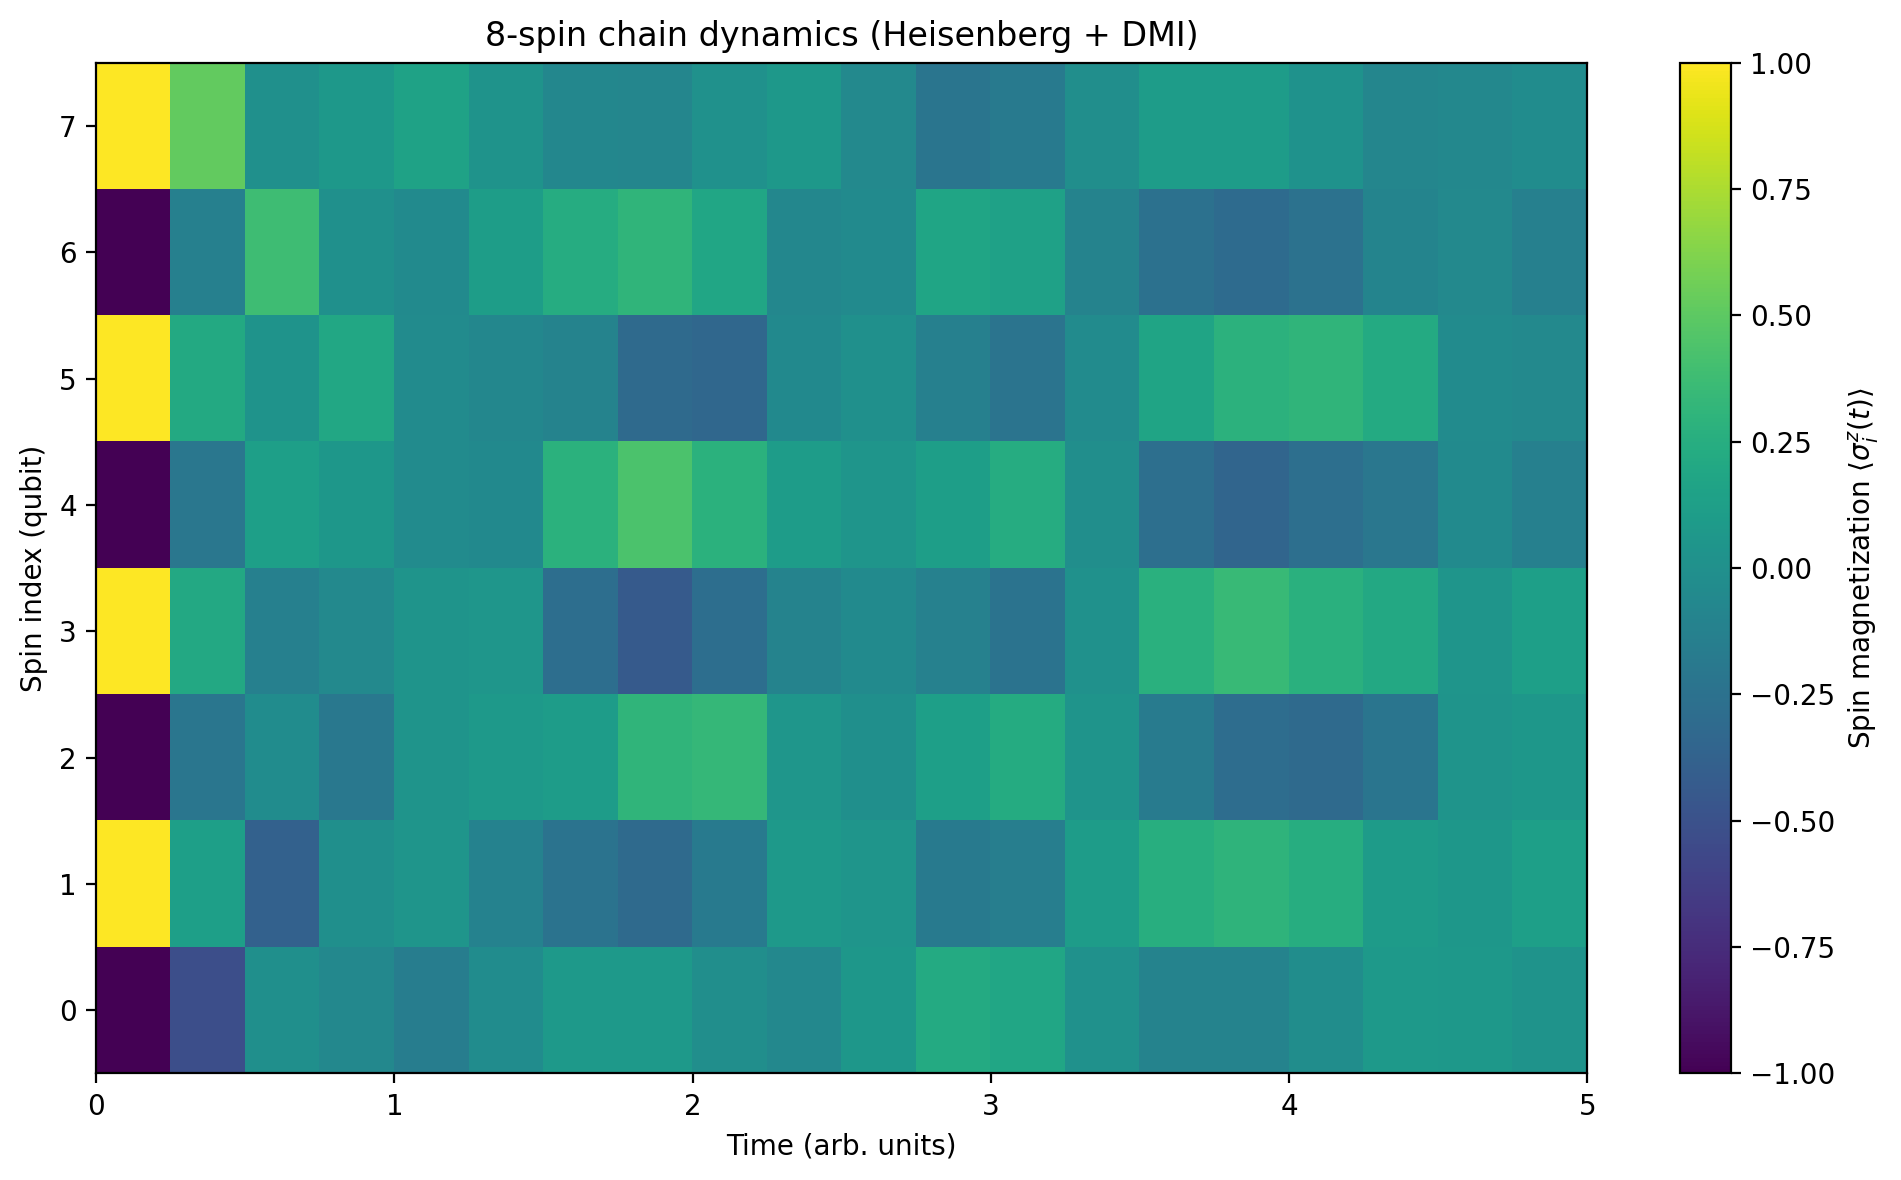

Circuit depth   : 145
CNOT count      : 39


<Figure size 1280x960 with 0 Axes>


All done – the two figures have been displayed.


In [22]:
#!/usr/bin/env python3
"""
Spintronic dynamics simulation using Qiskit.

The script builds the Hamiltonian of a 1‑D Heisenberg spin chain with
Dzyaloshinskii‑Moriya interaction (DMI) and an external magnetic field,
evolves an initial Néel state with a Trotter‑based Pauli‑evolution gate,
and visualizes

* a heat‑map of ⟨σᶻ_i(t)⟩ for every spin,
* a high‑DPI picture of a single Trotter‑step circuit.

All plots are displayed on‑screen sequentially.
"""

# ----------------------------------------------------------------------
# Imports
# ----------------------------------------------------------------------
from __future__ import annotations

import sys
from typing import List

import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.synthesis import LieTrotter

# Optional, newer synthesis methods – import if they exist
try:                                   # pragma: no‑cover
    from qiskit.synthesis import SuzukiTrotter, QDrift
except Exception:                      # pragma: no‑cover
    SuzukiTrotter = None   # type: ignore
    QDrift = None          # type: ignore

# ----------------------------------------------------------------------
# Simulation parameters
# ----------------------------------------------------------------------
N_SPINS: int = 8           # Number of qubits in the chain
TROTTER_STEPS: int = 4     # Repetitions of the (first‑order) Lie‑Trotter

# Hamiltonian coefficients
J_X: float = 1.0           # XX coupling
J_Y: float = 1.0           # YY coupling
J_Z: float = 1.2           # ZZ coupling (anisotropic)
H_Z: float = 0.5           # Uniform Z‑field
D_Z: float = 0.3           # DMI strength

# Time‑sampling for the heat‑map
T_FINAL: float = 5.0
T_STEPS: int = 20
TIMES: np.ndarray = np.linspace(0.0, T_FINAL, T_STEPS)


# ----------------------------------------------------------------------
# Helper functions
# ----------------------------------------------------------------------
def pauli_string(paulis: str, start: int, n_qubits: int) -> str:
    """Return a full‑length Pauli string.

    Args:
        paulis: Short Pauli word (e.g. "XX" or "Z").
        start: Index of the first qubit the word acts on.
        n_qubits: Total number of qubits in the circuit.

    Returns:
        A string of length ``n_qubits`` with the requested Pauli letters and
        identities elsewhere.
    """
    p_list = ["I"] * n_qubits
    for offset, p in enumerate(paulis):
        p_list[start + offset] = p
    return "".join(p_list)


def build_hamiltonian(
    n_spins: int,
    j_x: float,
    j_y: float,
    j_z: float,
    h_z: float,
    d_z: float,
) -> SparsePauliOp:
    """Construct the full system Hamiltonian.

    The Hamiltonian contains

    * nearest‑neighbour Heisenberg terms,
    * a DMI contribution ``D_z (X_i Y_{i+1} - Y_i X_{i+1})``,
    * a uniform Zeeman field ``h_z Z_i``.

    Returns:
        ``SparsePauliOp`` representing the Hamiltonian.
    """
    terms: List[str] = []
    coeffs: List[float] = []

    for i in range(n_spins - 1):
        # Heisenberg XX, YY, ZZ
        terms.append(pauli_string("XX", i, n_spins))
        coeffs.append(j_x)

        terms.append(pauli_string("YY", i, n_spins))
        coeffs.append(j_y)

        terms.append(pauli_string("ZZ", i, n_spins))
        coeffs.append(j_z)

        # DMI term: D_z * (X_i Y_{i+1} - Y_i X_{i+1})
        terms.append(pauli_string("XY", i, n_spins))
        coeffs.append(d_z)

        terms.append(pauli_string("YX", i, n_spins))
        coeffs.append(-d_z)

    # Uniform external field
    for i in range(n_spins):
        terms.append(pauli_string("Z", i, n_spins))
        coeffs.append(h_z)

    return SparsePauliOp(terms, coeffs=coeffs)


def neel_statevector(n_spins: int) -> Statevector:
    """Return the |0101…⟩ (Néel) product state as a ``Statevector``."""
    circuit = QuantumCircuit(n_spins)
    for q in range(1, n_spins, 2):
        circuit.x(q)
    return Statevector.from_instruction(circuit)


def run_simulation(
    hamiltonian: SparsePauliOp,
    n_spins: int,
    times: np.ndarray,
    trotter_steps: int,
) -> np.ndarray:
    """Evolve the Néel state and return ⟨σᶻ_i(t)⟩ for all spins and times.

    Returns:
        A ``(len(times), n_spins)`` array where entry ``[k, i]`` is
        ⟨σᶻ_i(t_k)⟩.
    """
    psi0 = neel_statevector(n_spins)

    # Build the list of Z observables once
    z_ops = [
        SparsePauliOp(pauli_string("Z", i, n_spins), coeffs=[1.0])
        for i in range(n_spins)
    ]

    dynamics = np.zeros((len(times), n_spins), dtype=float)

    for idx, t in enumerate(times):
        print(f"Simulating time t = {t:.3f} ...", flush=True)

        evo_gate = PauliEvolutionGate(
            hamiltonian,
            time=t,
            synthesis=LieTrotter(reps=trotter_steps),
        )
        psi_t = psi0.evolve(evo_gate)

        for i, op in enumerate(z_ops):
            exp_val = psi_t.expectation_value(op)
            dynamics[idx, i] = float(np.real_if_close(exp_val))

    print("Simulation finished.")
    return dynamics


def plot_heatmap(spin_data: np.ndarray, times: np.ndarray, n_spins: int) -> None:
    """Draw a heat‑map of ⟨σᶻ_i(t)⟩."""
    print("Plotting heat‑map ...")
    plt.figure(figsize=(10, 6))

    im = plt.imshow(
        spin_data.T,
        aspect="auto",
        interpolation="nearest",
        origin="lower",
        extent=[times[0], times[-1], -0.5, n_spins - 0.5],
        cmap="viridis",
        vmin=-1,
        vmax=+1,
    )
    plt.colorbar(im, label=r"Spin magnetization $\langle \sigma^z_i(t) \rangle$")
    plt.xlabel("Time (arb. units)")
    plt.ylabel("Spin index (qubit)")
    plt.title(f"{n_spins}-spin chain dynamics (Heisenberg + DMI)")
    plt.tight_layout()
    plt.show()


# ----------------------------------------------------------------------
# Optimized circuit building
# ----------------------------------------------------------------------
def _optimized_circuit(
    hamiltonian: SparsePauliOp,
    n_spins: int,
    t_step: float,
    *,
    method: str = "lie",          # "lie", "suzuki" or "qdrift"
    suzuki_order: int = 2,
    qdrift_samples: int = 30,
    optimization_level: int = 3,
) -> QuantumCircuit:
    """Return a depth‑optimized circuit for a single Trotter step.

    Parameters
    ----------
    hamiltonian
        System Hamiltonian.
    n_spins
        Number of qubits.
    t_step
        Evolution time for the step.
    method
        Synthesis method: ``"lie"`` (default Lie‑Trotter), ``"suzuki"``
        (higher‑order product formula), or ``"qdrift"`` (stochastic).
    suzuki_order
        Order of the Suzuki formula (used only if ``method=="suzuki"``).
    qdrift_samples
        Number of Pauli terms sampled (used only if ``method=="qdrift"``).
    optimization_level
        Transpiler optimization level (0‑3).  Level‑3 already performs
        CNOT‑cancellation, commutation‑cancellation and 1‑qubit‑gate fusion.

    Returns
    -------
    QuantumCircuit
        The optimized circuit ready for drawing or execution.
    """
    # ------------------------------------------------------------------
    # Choose the synthesis routine
    # ------------------------------------------------------------------
    if method == "suzuki":
        if SuzukiTrotter is None:  # pragma: no‑cover
            raise RuntimeError(
                "SuzukiTrotter not available in this Qiskit version. "
                "Use method='lie' instead."
            )
        synthesis = SuzukiTrotter(reps=1, order=suzuki_order)
    elif method == "qdrift":
        if QDrift is None:  # pragma: no‑cover
            raise RuntimeError(
                "QDrift not available in this Qiskit version. "
                "Use method='lie' instead."
            )
        synthesis = QDrift(num_terms=qdrift_samples, seed=12345)
    else:  # default = "lie"
        synthesis = LieTrotter(reps=1)

    # ------------------------------------------------------------------
    # Build the high‑level circuit (state‑prep + evolution)
    # ------------------------------------------------------------------
    evo_gate = PauliEvolutionGate(hamiltonian, time=t_step, synthesis=synthesis)

    qc = QuantumCircuit(n_spins)
    for q in range(1, n_spins, 2):
        qc.x(q)               # Néel preparation
    qc.append(evo_gate, range(n_spins))

    # ------------------------------------------------------------------
    # Aggressive transpilation (level‑3) – no need to import individual passes
    # ------------------------------------------------------------------
    basis = ["cx", "rz", "rx", "ry"]  # generic basis for a state‑vector simulator
    qc_opt = transpile(
        qc,
        basis_gates=basis,
        optimization_level=optimization_level,
        seed_transpiler=42,
    )
    return qc_opt


def plot_optimized_circuit(
    hamiltonian: SparsePauliOp,
    n_spins: int,
    t_step: float,
    dpi: int = 200,
) -> None:
    """Draw a high‑DPI picture of a single optimized Trotter step."""
    # Use the second‑order Suzuki formula (good accuracy / modest depth)
    qc_opt = _optimized_circuit(
        hamiltonian,
        n_spins,
        t_step,
        method="suzuki",
        suzuki_order=2,
        optimization_level=3,
    )

    print(f"Circuit depth   : {qc_opt.depth()}")
    print(f"CNOT count      : {qc_opt.count_ops().get('cx', 0)}")

    plt.rcParams["figure.dpi"] = dpi
    fig = qc_opt.draw("mpl", fold=-1, style={"fontsize": 9})
    fig.suptitle(
        "Optimized single‑step Trotter circuit (Suzuki‑2)",
        fontsize=12,
    )
    plt.tight_layout()
    plt.show()


# ----------------------------------------------------------------------
# Main workflow
# ----------------------------------------------------------------------
def main() -> None:
    """Run the full workflow: build → simulate → visualize."""
    #  Build the Hamiltonian
    ham = build_hamiltonian(N_SPINS, J_X, J_Y, J_Z, H_Z, D_Z)

    #  Run the state‑vector simulation
    dynamics = run_simulation(ham, N_SPINS, TIMES, TROTTER_STEPS)

    #  Plot the spin‑magnetization heat‑map
    plot_heatmap(dynamics, TIMES, N_SPINS)

    #  Plot a representative circuit (use the smallest time step)
    dt = np.diff(TIMES).min()
    plot_optimized_circuit(ham, N_SPINS, dt, dpi=200)

    print("\nAll done – the two figures have been displayed.")


if __name__ == "__main__":
    # Provide a clear error message if a required package is missing.
    try:
        main()
    except ImportError as exc:
        missing_pkg = str(exc).split("'")[1]
        sys.stderr.write(
            f"\nMissing package '{missing_pkg}'. "
            "Install the required dependencies with:\n"
            "    pip install qiskit qiskit-aer pylatexenc\n"
        )
        sys.exit(1)

Circuit depth   : 145
CNOT count      : 39


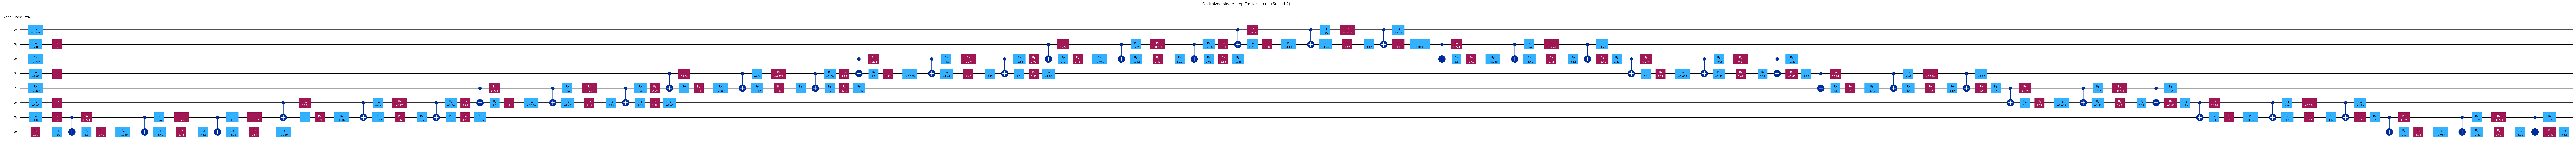

<Figure size 1280x960 with 0 Axes>

In [23]:
# --------------------------------------------------------------
# Plot the optimized Trotter‑step circuit
# --------------------------------------------------------------

# ------------------------------------------------------------------
# 0 – Imports needed only for the visualization part
# ------------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib

# IPython utilities – only available inside a notebook / interactive shell
try:                                   # pragma: no‑cover
    from IPython.display import display
    _in_ipython = True
except Exception:                      # pragma: no‑cover
    _in_ipython = False

# ------------------------------------------------------------------
# 1 – Ensure Matplotlib has a usable backend
# ------------------------------------------------------------------
# In a notebook the user usually runs `%matplotlib inline` or `%matplotlib notebook`.
# If the script is executed in a non‑interactive environment we fall back to the
# non‑GUI Agg backend (the figure can still be saved or displayed via IPython).
if not matplotlib.get_backend().lower().startswith("agg"):
    # A GUI backend is already loaded – keep it (it will pop‑up a window).
    pass
else:
    # Force Agg only when no interactive backend is present.
    matplotlib.use("Agg")

# ------------------------------------------------------------------
# 2 – Build the Hamiltonian (exactly as in the main script)
# ------------------------------------------------------------------
hamiltonian = build_hamiltonian(N_SPINS, J_X, J_Y, J_Z, H_Z, D_Z)

# ------------------------------------------------------------------
# 3 – Choose a small evolution time (spacing between the first two snapshots)
# ------------------------------------------------------------------
t_step = np.diff(TIMES).min()   # = TIMES[1] - TIMES[0]

# ------------------------------------------------------------------
# 4 – Create the depth‑optimized circuit
# ------------------------------------------------------------------
qc_opt = _optimized_circuit(
    hamiltonian,
    n_spins=N_SPINS,
    t_step=t_step,
    method="suzuki",      # try "lie" or "qdrift" as alternatives
    suzuki_order=2,
    optimization_level=3,
)

# ------------------------------------------------------------------
# 5 – Print basic statistics
# ------------------------------------------------------------------
print(f"Circuit depth   : {qc_opt.depth()}")
print(f"CNOT count      : {qc_opt.count_ops().get('cx', 0)}")

# ------------------------------------------------------------------
# 6 – Draw the circuit (high‑DPI)
# ------------------------------------------------------------------
plt.rcParams["figure.dpi"] = 200               # you can change the resolution

# ``draw('mpl')`` returns a Matplotlib ``Figure`` object.
fig = qc_opt.draw(
    "mpl",                # use the Matplotlib drawer
    fold=-1,              # keep each qubit on a single line
    style={"fontsize": 9},
)

# Optional – give the figure a title
fig.suptitle(
    "Optimized single‑step Trotter circuit (Suzuki‑2)",
    fontsize=12,
)

plt.tight_layout()

# ------------------------------------------------------------------
# 7 – Display the figure
# ------------------------------------------------------------------
if _in_ipython:
    # In notebooks/IPython explicitly display the Figure object.
    display(fig)
else:
    # In a plain script we try to open a window.  If the backend is Agg,
    # ``plt.show()`` will do nothing, so we also save a PNG as a fallback.
    try:
        plt.show()
    except Exception:  # pragma: no‑cover
        pass

    # Save a file that can be opened manually if the window never appeared.
    fig.savefig("circuit.png")
    print("Figure saved as 'circuit.png'.")


Simulating t = 0.000 ...
Simulating t = 0.263 ...
Simulating t = 0.526 ...
Simulating t = 0.789 ...
Simulating t = 1.053 ...
Simulating t = 1.316 ...
Simulating t = 1.579 ...
Simulating t = 1.842 ...
Simulating t = 2.105 ...
Simulating t = 2.368 ...
Simulating t = 2.632 ...
Simulating t = 2.895 ...
Simulating t = 3.158 ...
Simulating t = 3.421 ...
Simulating t = 3.684 ...
Simulating t = 3.947 ...
Simulating t = 4.211 ...
Simulating t = 4.474 ...
Simulating t = 4.737 ...
Simulating t = 5.000 ...

Plotting heat‑map of ⟨σᶻᵢ(t)⟩


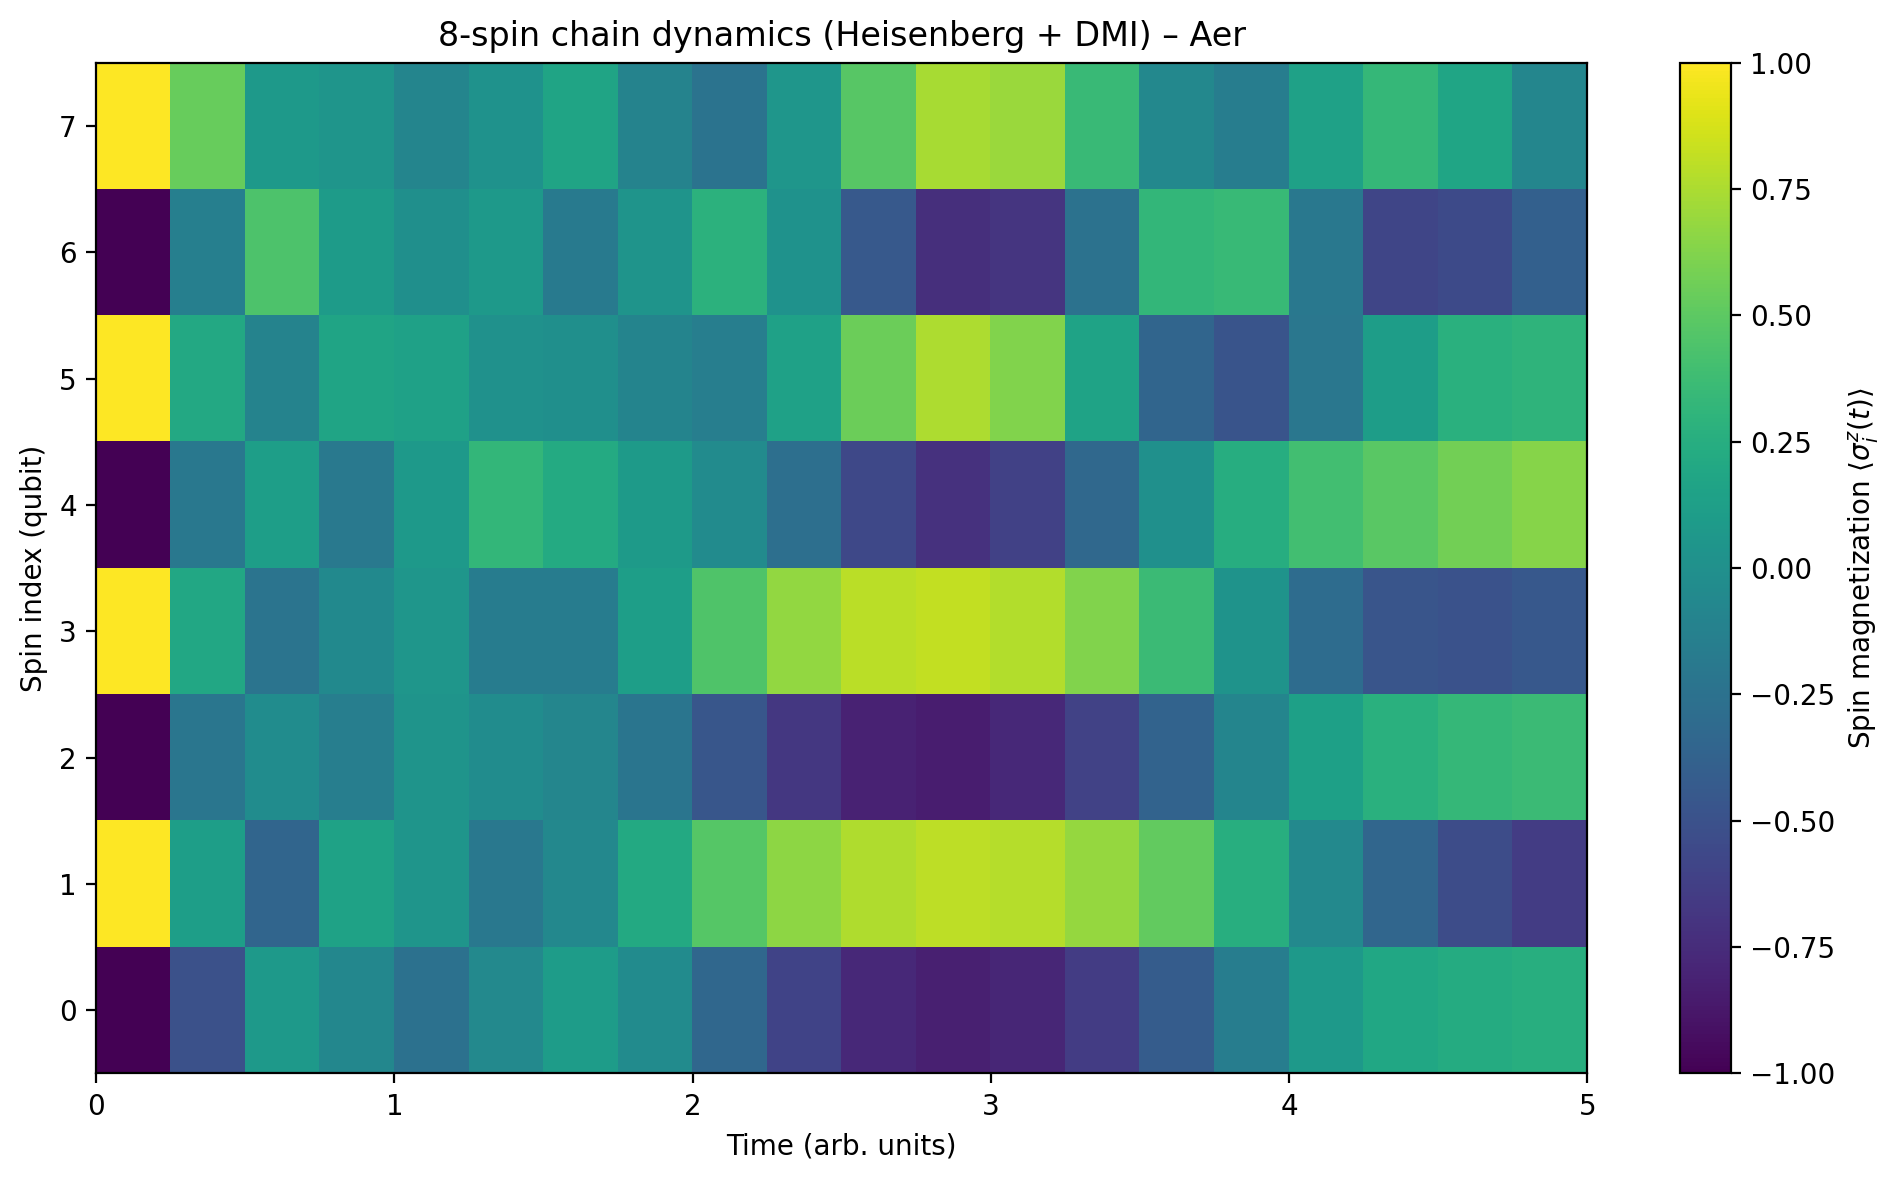

In [24]:
# --------------------------------------------------------------
# Simulate magnetization dynamics with Qiskit‑Aer (statevector)
# --------------------------------------------------------------

# ------------------------------------------------------------------
# 0 – Imports (only needed for this cell)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.synthesis import LieTrotter

# ------------------------------------------------------------------
# 1 – Initialize the Aer state‑vector backend
# ------------------------------------------------------------------
# Prefer the newer AerSimulator; fall back to the classic simulator.
try:                                            # Qiskit ≥ 0.44
    from qiskit_aer import AerSimulator

    aer_backend = AerSimulator()                # default: method='automatic'
except Exception:                               # pragma: no‑cover
    from qiskit import Aer

    aer_backend = Aer.get_backend("statevector_simulator")

# ------------------------------------------------------------------
# 2 – Build the Hamiltonian (uses the helper already defined)
# ------------------------------------------------------------------
ham = build_hamiltonian(N_SPINS, J_X, J_Y, J_Z, H_Z, D_Z)

# ------------------------------------------------------------------
# 3 – Pre‑compute the local Z observables (one per qubit)
# ------------------------------------------------------------------
z_ops = [
    SparsePauliOp(pauli_string("Z", i, N_SPINS), coeffs=[1.0])
    for i in range(N_SPINS)
]

# ------------------------------------------------------------------
# 4 – Allocate the container for the dynamics
# ------------------------------------------------------------------
magnetization = np.zeros((len(TIMES), N_SPINS), dtype=float)


def _statevector_from_result(res, label="final"):
    """
    Extract the saved statevector from a Qiskit‑Aer Result object.

    Parameters
    ----------
    res : qiskit.result.Result
        The result returned by ``backend.run(...).result()``.
    label : str, optional
        The key used when the circuit called ``save_statevector(label)``.
        The default ``'final'`` matches the label used below.

    Returns
    -------
    np.ndarray
        The final statevector as a 1‑D complex NumPy array.
    """
    # The new API: ``result.get_statevector(idx)`` works for the
    # first (and only) experiment.
    try:
        return res.get_statevector(0)
    except Exception:
        # Fallback for older versions – the data dict uses the label.
        try:
            return res.data(0)[label]
        except Exception as exc:
            raise RuntimeError("Statevector could not be retrieved.") from exc


# ------------------------------------------------------------------
# 5 – Main simulation loop (one circuit per snapshot)
# ------------------------------------------------------------------
for t_idx, t in enumerate(TIMES):
    print(f"Simulating t = {t:.3f} ...", flush=True)

    # ----- a) Build the circuit for this time point -----------------
    qc = QuantumCircuit(N_SPINS)

    # Néel state preparation: |0101…⟩
    for q in range(1, N_SPINS, 2):
        qc.x(q)

    # First‑order Lie‑Trotter evolution
    evo_gate = PauliEvolutionGate(
        ham,
        time=t,
        synthesis=LieTrotter(reps=TROTTER_STEPS),
    )
    qc.append(evo_gate, range(N_SPINS))

    # ----- b) Insert an explicit save‑statevector instruction -------
    # The label “final” will be used later to pull the vector out.
    qc.save_statevector(label="final")

    # ----- c) Fully decompose the high‑level gate ------------------
    # Six levels of recursion usually expose every CX / single‑qubit
    # rotation that the Aer backend understands.
    qc = qc.decompose(reps=6)

    # ----- d) Transpile for the Aer backend -------------------------
    qc_t = transpile(
        qc,
        backend=aer_backend,
        optimization_level=3,
    )

    # ----- e) Run and retrieve the final statevector ---------------
    result = aer_backend.run(qc_t).result()
    final_state = _statevector_from_result(result, label="final")

    # ----- f) Compute ⟨σᶻᵢ⟩ for each spin -------------------------
    sv = Statevector(final_state)
    for i, op in enumerate(z_ops):
        exp_val = sv.expectation_value(op)
        magnetization[t_idx, i] = float(np.real_if_close(exp_val))

# ------------------------------------------------------------------
# 6 – Plot the magnetization heat‑map
# ------------------------------------------------------------------
print("\nPlotting heat‑map of ⟨σᶻᵢ(t)⟩")
plt.figure(figsize=(10, 6))
im = plt.imshow(
    magnetization.T,                     # transpose → spins on y‑axis
    aspect="auto",
    interpolation="nearest",
    origin="lower",
    extent=[TIMES[0], TIMES[-1], -0.5, N_SPINS - 0.5],
    cmap="viridis",
    vmin=-1,
    vmax=+1,
)
plt.colorbar(im, label=r"Spin magnetization $\langle \sigma^z_i(t) \rangle$")
plt.xlabel("Time (arb. units)")
plt.ylabel("Spin index (qubit)")
plt.title(f"{N_SPINS}-spin chain dynamics (Heisenberg + DMI) – Aer")
plt.tight_layout()
plt.show()


Simulating t = 0.000 ...
Simulating t = 0.263 ...
Simulating t = 0.526 ...
Simulating t = 0.789 ...
Simulating t = 1.053 ...
Simulating t = 1.316 ...
Simulating t = 1.579 ...
Simulating t = 1.842 ...
Simulating t = 2.105 ...
Simulating t = 2.368 ...
Simulating t = 2.632 ...
Simulating t = 2.895 ...
Simulating t = 3.158 ...
Simulating t = 3.421 ...
Simulating t = 3.684 ...
Simulating t = 3.947 ...
Simulating t = 4.211 ...
Simulating t = 4.474 ...
Simulating t = 4.737 ...
Simulating t = 5.000 ...

Plotting heat‑map of ⟨σᶻᵢ(t)⟩


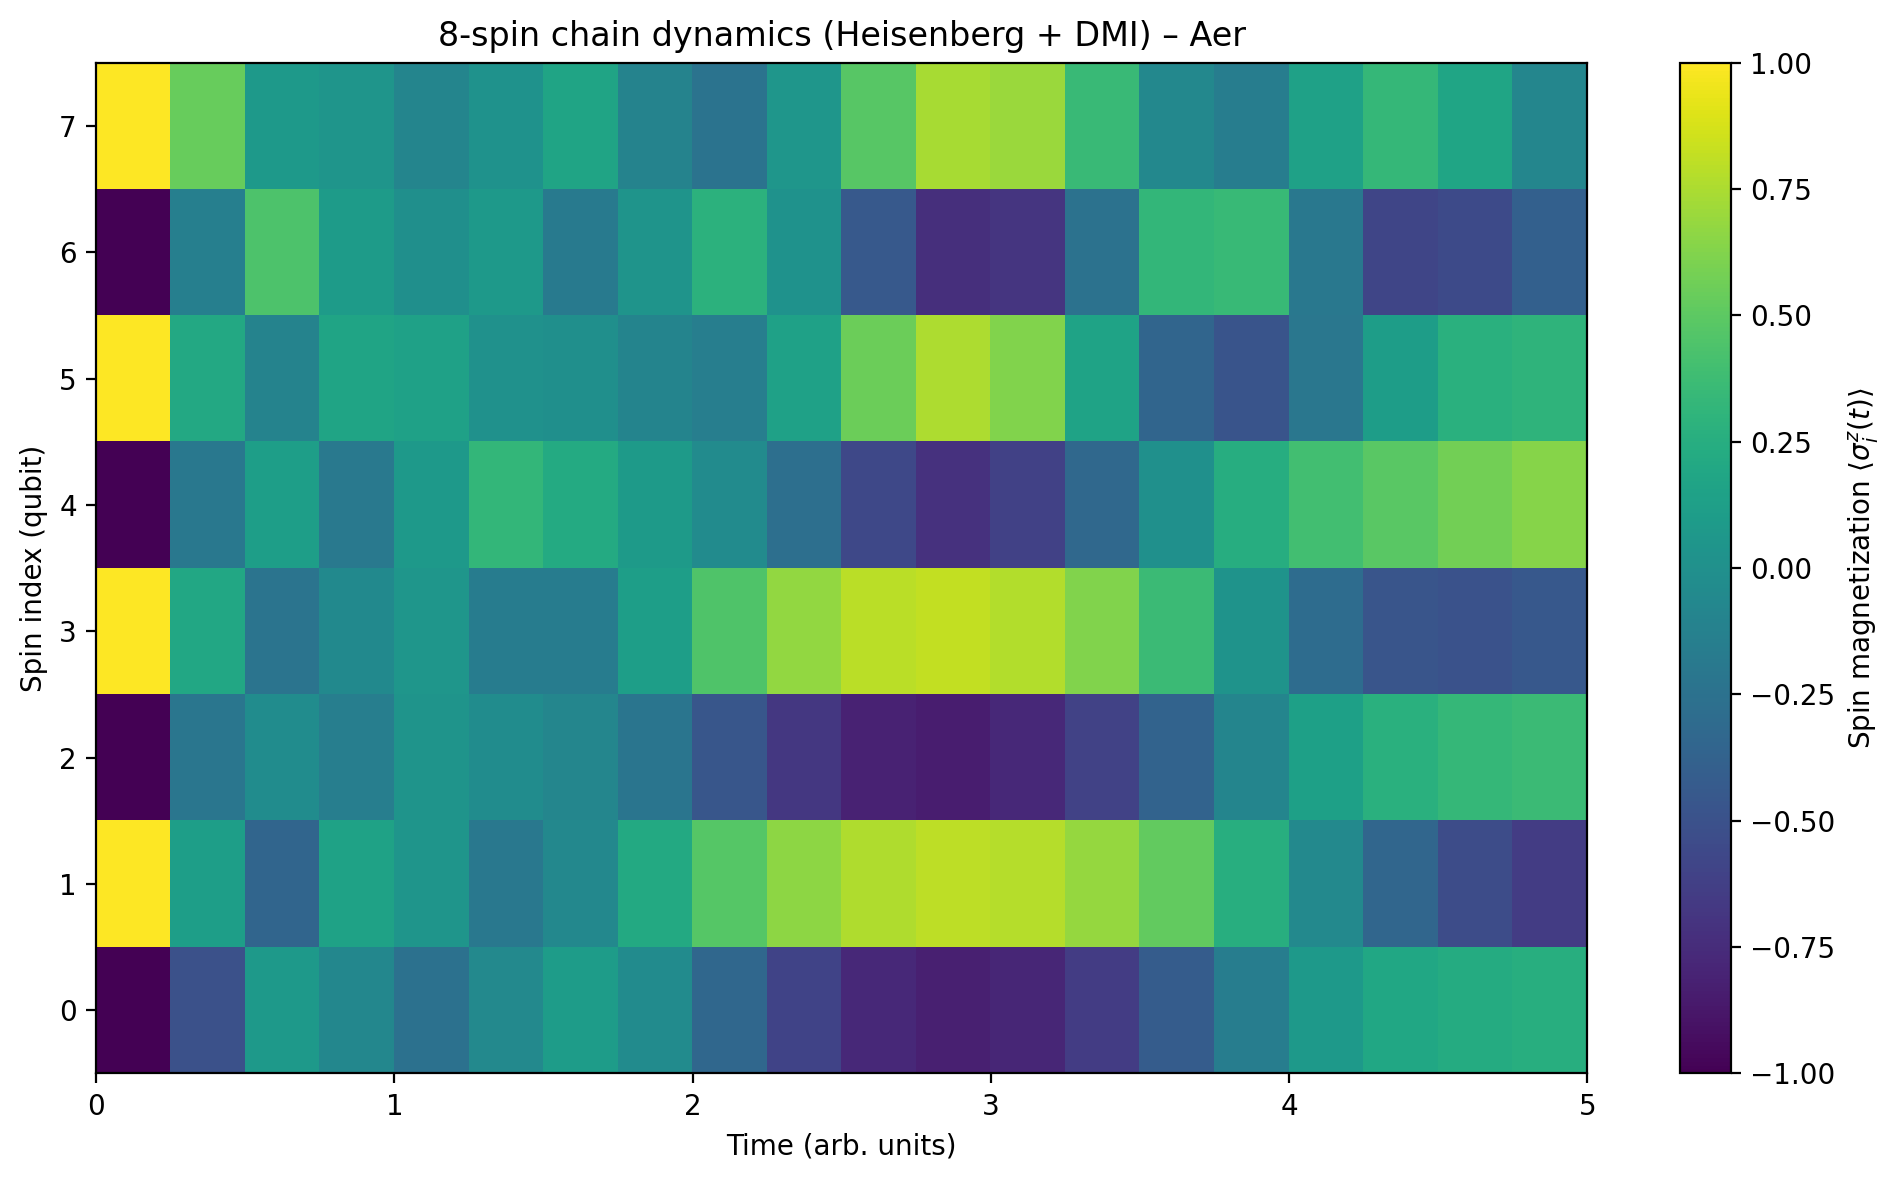

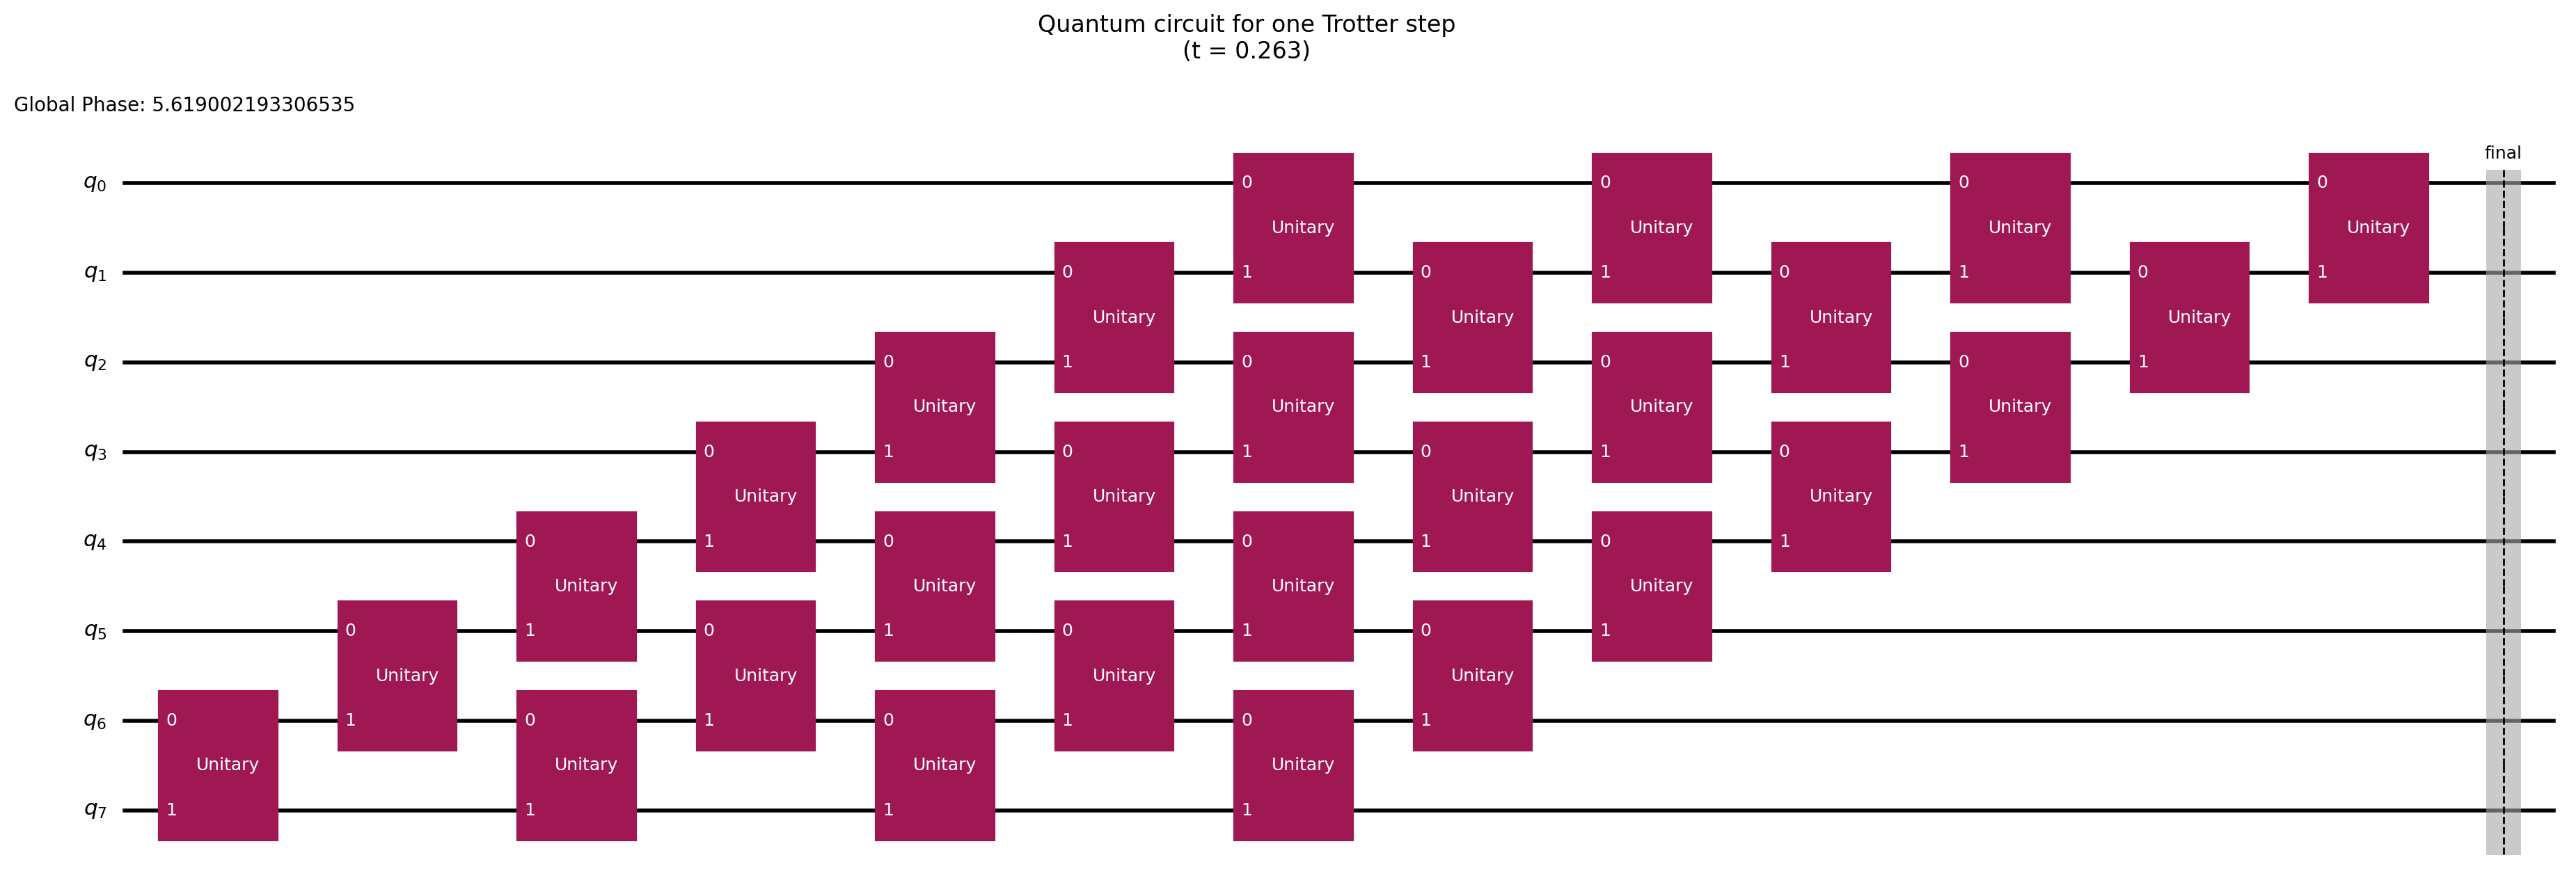

<Figure size 1280x960 with 0 Axes>

In [25]:
# --------------------------------------------------------------
# Magnetization dynamics (Aer) + visualization of the circuit
# --------------------------------------------------------------

# ------------------------------------------------------------------
# 0 – Imports (only needed for this cell)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.synthesis import LieTrotter

# ``display`` works in notebooks; harmless in a plain script.
try:                                            # pragma: no‑cover
    from IPython.display import display
    _in_ipython = True
except Exception:                               # pragma: no‑cover
    _in_ipython = False

# ------------------------------------------------------------------
# 1 – Initialize the Aer backend (newer AerSimulator if available)
# ------------------------------------------------------------------
try:                                            # Qiskit ≥ 0.44
    from qiskit_aer import AerSimulator

    aer_backend = AerSimulator()                # method='automatic' → statevector by default
except Exception:                               # pragma: no‑cover
    from qiskit import Aer

    aer_backend = Aer.get_backend("statevector_simulator")

# ------------------------------------------------------------------
# 2 – Build the Hamiltonian (uses the helper defined earlier)
# ------------------------------------------------------------------
ham = build_hamiltonian(N_SPINS, J_X, J_Y, J_Z, H_Z, D_Z)

# ------------------------------------------------------------------
# 3 – Pre‑compute the Z observables (one per qubit)
# ------------------------------------------------------------------
z_ops = [
    SparsePauliOp(pauli_string("Z", i, N_SPINS), coeffs=[1.0])
    for i in range(N_SPINS)
]

# ------------------------------------------------------------------
# 4 – Container for the magnetization data
# ------------------------------------------------------------------
magnetization = np.zeros((len(TIMES), N_SPINS), dtype=float)


def _statevector_from_result(res, label="final"):
    """
    Extract a saved statevector from an Aer ``Result`` object.

    Parameters
    ----------
    res : qiskit.result.Result
        Result returned by ``backend.run(...).result()``.
    label : str, optional
        The key given to ``save_statevector`` (default ``'final'``).

    Returns
    -------
    np.ndarray
        1‑D complex NumPy array containing the final statevector.
    """
    # Newer API – ``result.get_statevector(idx)`` works for a single experiment.
    try:
        return res.get_statevector(0)
    except Exception:
        # Older API – the data dict stores the vector under the label.
        try:
            return res.data(0)[label]
        except Exception as exc:  # pragma: no‑cover
            raise RuntimeError("Statevector could not be retrieved.") from exc


# ------------------------------------------------------------------
# 5 – Run the dynamics (one circuit per snapshot)
# ------------------------------------------------------------------
for t_idx, t in enumerate(TIMES):
    print(f"Simulating t = {t:.3f} ...", flush=True)

    # ----- a) Build the circuit for this time point -----------------
    qc = QuantumCircuit(N_SPINS)

    # Néel state preparation |0101…⟩
    for q in range(1, N_SPINS, 2):
        qc.x(q)

    # First‑order Lie‑Trotter evolution
    evo_gate = PauliEvolutionGate(
        ham,
        time=t,
        synthesis=LieTrotter(reps=TROTTER_STEPS),
    )
    qc.append(evo_gate, range(N_SPINS))

    # Save the final statevector – this forces Aer to return it.
    qc.save_statevector(label="final")

    # ----- b) Decompose the high‑level gate into native gates -------
    # Six recursion levels are enough to expose every CX / Rx / Ry / Rz.
    qc = qc.decompose(reps=6)

    # ----- c) Transpile for the Aer backend -------------------------
    qc_t = transpile(
        qc,
        backend=aer_backend,
        optimization_level=3,
    )

    # ----- d) Run and fetch the final statevector -------------------
    result = aer_backend.run(qc_t).result()
    final_state = _statevector_from_result(result, label="final")

    # ----- e) Compute ⟨σᶻᵢ⟩ for each spin -------------------------
    sv = Statevector(final_state)
    for i, op in enumerate(z_ops):
        exp_val = sv.expectation_value(op)
        magnetization[t_idx, i] = float(np.real_if_close(exp_val))

# ------------------------------------------------------------------
# 6 – Plot the magnetization heat‑map
# ------------------------------------------------------------------
print("\nPlotting heat‑map of ⟨σᶻᵢ(t)⟩")
plt.figure(figsize=(10, 6))
im = plt.imshow(
    magnetization.T,                     # transpose → spins on y‑axis
    aspect="auto",
    interpolation="nearest",
    origin="lower",
    extent=[TIMES[0], TIMES[-1], -0.5, N_SPINS - 0.5],
    cmap="viridis",
    vmin=-1,
    vmax=+1,
)
plt.colorbar(im, label=r"Spin magnetization $\langle \sigma^z_i(t) \rangle$")
plt.xlabel("Time (arb. units)")
plt.ylabel("Spin index (qubit)")
plt.title(f"{N_SPINS}-spin chain dynamics (Heisenberg + DMI) – Aer")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 7 – Draw the circuit used for a single Trotter step
# ------------------------------------------------------------------
# Choose the first non‑zero snapshot (gives a non‑trivial evolution).
sample_time = TIMES[1] if len(TIMES) > 1 else TIMES[0]

# Build the exact circuit that was simulated for this time.
def build_sample_circuit(t):
    """Return a fully‑decomposed circuit for time ``t``."""
    qc = QuantumCircuit(N_SPINS)

    # Néel preparation
    for q in range(1, N_SPINS, 2):
        qc.x(q)

    # Evolution
    evo = PauliEvolutionGate(
        ham,
        time=t,
        synthesis=LieTrotter(reps=TROTTER_STEPS),
    )
    qc.append(evo, range(N_SPINS))

    # Insert a dummy save (makes no difference for drawing)
    qc.save_statevector(label="final")
    # Decompose to native gates
    return qc.decompose(reps=6)


qc_sample = build_sample_circuit(sample_time)

# Transpile exactly as we did for the simulation (so the picture matches).
qc_sample_t = transpile(
    qc_sample,
    backend=aer_backend,
    optimization_level=3,
)

# High‑DPI drawing
plt.rcParams["figure.dpi"] = 200
fig = qc_sample_t.draw(
    "mpl",
    fold=-1,                   # keep each qubit on a single line
    style={"fontsize": 9},
)
fig.suptitle(
    f"Quantum circuit for one Trotter step\n(t = {sample_time:.3f})",
    fontsize=12,
)
plt.tight_layout()

# Show the figure – works in notebooks and as a script.
if _in_ipython:
    display(fig)
else:
    plt.show()
